In [18]:
import sys
import requests
from bs4 import BeautifulSoup
import time
import random
from fake_useragent import UserAgent
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import re
import time
import seaborn as sns
%matplotlib inline
import pickle
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
import math
from scipy.stats import boxcox
import matplotlib.style as style
import seaborn as sns
from sklearn import metrics

In [ ]:
from dataframe_cleaning import split_dataframe_by_position
from espn_scraping_cleaning import ESPN_FF_Table
from sports_ref_scraping_cleaning import sports_ref_stat_scrape,sports_ref_cleaning
from sports_ref_scraping_cleaning import scrape_2015_Fantasy_Points_Sports_Ref,sports_ref_cleaning_2018
from regression_testing import linear_regression_avg,find_lambda,lambda_tester,Lasso_Reg
from regression_testing import regression_avg
from graphing_functions import heatMap
from dataframe_cleaning import log_function,log_function_shift



# Initial Data Scraping And Cleaning

## ESPN

In [4]:
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

selenium.webdriver.chrome.webdriver.WebDriver

In [14]:
url_2018="http://games.espn.com/ffl/leaders?&slotCategoryId="
url_2017="http://games.espn.com/ffl/leaders?&seasonTotals=true&seasonId=2017&slotCategoryId="
url_list=[url_2018,url_2017]

In [ ]:
df_ESPN=ESPN_FF_Table(url_list)

In [453]:
df_ESPN.head()

,PTS,PLAYER_NAME,POS
1,385.8,saquonbarkley18,RB
2,385.5,christianmccaffrey18,RB
3,372.1,toddgurley18,RB
4,354.2,alvinkamara18,RB
5,329.1,ezekielelliott18,RB


## Pro Football Reference (Sports Reference)

### Stats Scraping

In [294]:
url18=["https://www.pro-football-reference.com/years/2017/rushing.htm","https://www.pro-football-reference.com/years/2017/receiving.htm"]
url17=["https://www.pro-football-reference.com/years/2016/rushing.htm","https://www.pro-football-reference.com/years/2016/receiving.htm"]
url16=["https://www.pro-football-reference.com/years/2015/rushing.htm","https://www.pro-football-reference.com/years/2015/receiving.htm"]
urlList=[url18,url17,url16]


In [482]:
df_rush,df_rec=sports_ref_stat_scrape(urlList)
df_sports_ref=sports_ref_cleaning(df_rush,df_rec)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [483]:
df_sports_ref.columns

Index(['Player', 'Tgt', 'Rec', 'Ctch%', 'Yds_Rec', 'Y/R', 'TD_Rec', 'Lng_Rec',
       'R/G', 'Y/G_Rec', 'Fmb_Rec', 'Age_Rush', 'Pos_Rush', 'G_Rush',
       'GS_Rush', 'Att', 'Yds_Rush', 'TD_Rush', 'Lng_Rush', 'Y/A', 'Y/G_Rush'],
      dtype='object')

### Fantasy Points Scraping (For 2015 data)

In [510]:
url="https://www.pro-football-reference.com/years/2016/fantasy.htm"
Play_Stat_Regex=re.compile("sortable stats_table")

In [511]:
df_sports_ref_fp_15=scrape_2015_Fantasy_Points_Sports_Ref(url)

### Pull in 2018 Stats for Predictions

In [106]:
url=["https://www.pro-football-reference.com/years/2018/rushing.htm","https://www.pro-football-reference.com/years/2018/receiving.htm"]
Play_Stat_Regex=re.compile("sortable stats_table")


In [ ]:
df_sports_ref_combined_18=sports_ref_cleaning_2018(url,Play_Stat_Regex)

In [ ]:
df_rb_18, df_wr_18 = split_dataframe_by_position(df_sports_ref_combined_18)

# Merging Data

## Merge Different Year's Fantasy Points Into Final DataFrame

In [515]:
complete_df_FP=df_ESPN.merge(df_sports_ref_fp_15,how='outer',left_on=['PLAYER_NAME', 'PTS', 'POS'],right_on=['PLAYER_NAME', 'PTS', 'POS'])
complete_df_FP.drop_duplicates(subset='PLAYER_NAME',keep='first',inplace=True)


## Merge Statistics with Fantasy Points

In [577]:
from dataframe_cleaning import set_pos_if_null
from dataframe_cleaning import convert_series_to_float

In [592]:
final_df = complete_df_FP.merge(df_sports_ref,
                                how='outer',left_on='PLAYER_NAME',right_on='Player')

## Clean Final Merged DataFrame

In [102]:
final_df.dropna(axis=0,how='any',subset=['PTS'],inplace=True)
final_df['POS']=final_df.apply(lambda x: set_pos_if_null(x),axis=1)
convert_series_to_float(final_df)
temp_POS_column=final_df['POS']
final_df=final_df.select_dtypes(exclude =['object']).copy()
final_df['POS']=temp_POS_column
final_df.dropna(thresh=5,inplace=True)
final_df.fillna(0,inplace=True)

# Split Data Into WR Data and RB Data

In [607]:
df_rb=final_df[final_df['POS'].str[:2].str.lower()=='rb']
df_wr=final_df[final_df['POS'].str[:2].str.lower()=='wr']

In [51]:
maskrb=(df_rb['PTS']>0) |\
           (df_rb['Yds_Rush']>100) |\
          (df_rb['Yds_Rec']>100)
maskwr=(df_wr['PTS']>0) |\
           (df_wr['Yds_Rush']>100) |\
          (df_wr['Yds_Rec']>100)

In [52]:
df_rb=df_rb[maskrb]
df_wr=df_wr[maskwr]

In [616]:
df_rb=df_rb.reset_index(drop=True)
df_wr=df_wr.reset_index(drop=True)

In [631]:
df_rb=df_rb.select_dtypes(exclude =['object']).copy()
df_wr=df_wr.select_dtypes(exclude =['object']).copy()

# Correlation Check For Variables

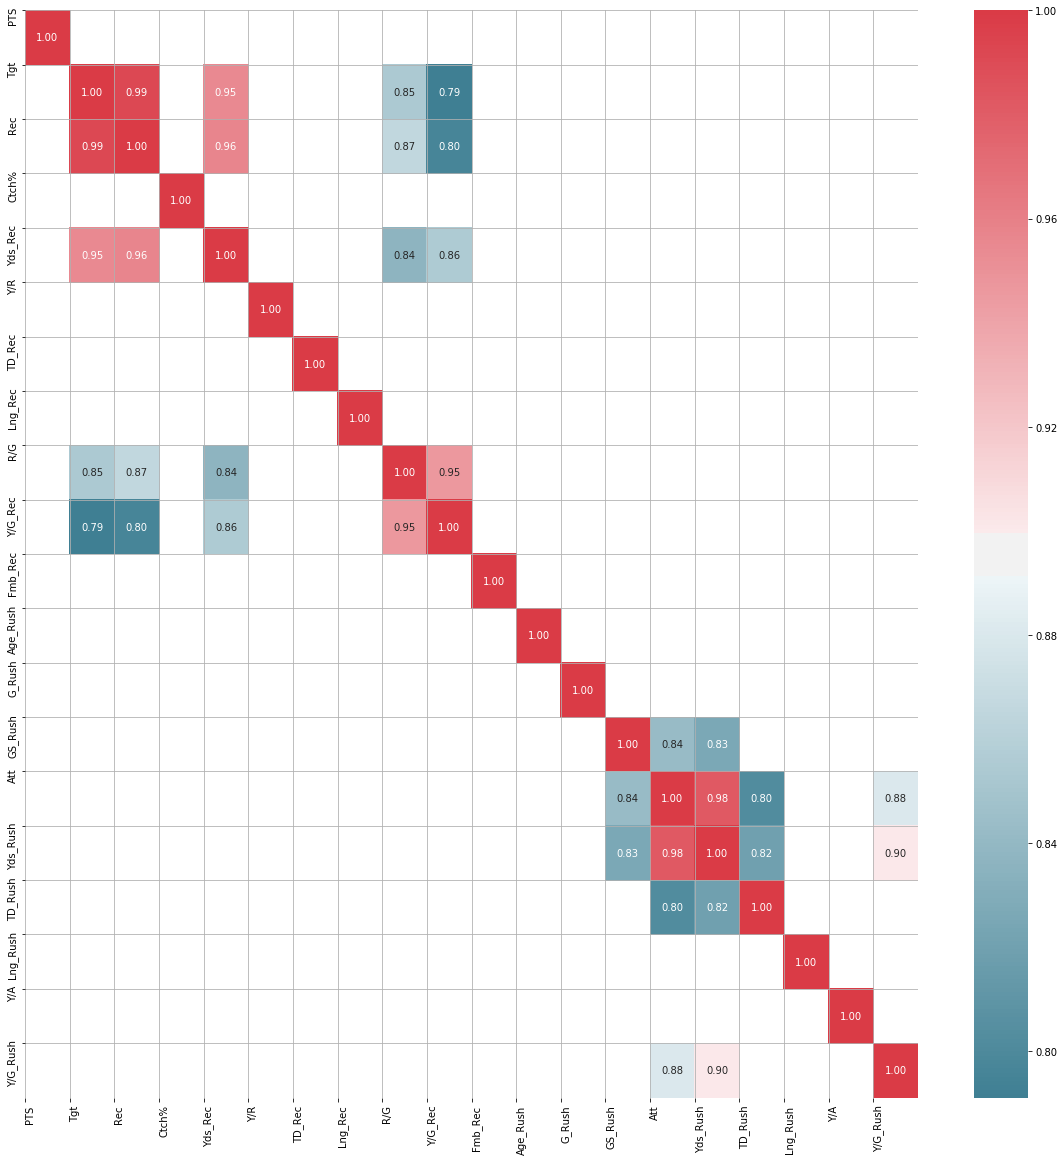

In [635]:
heatMap(df_rb)

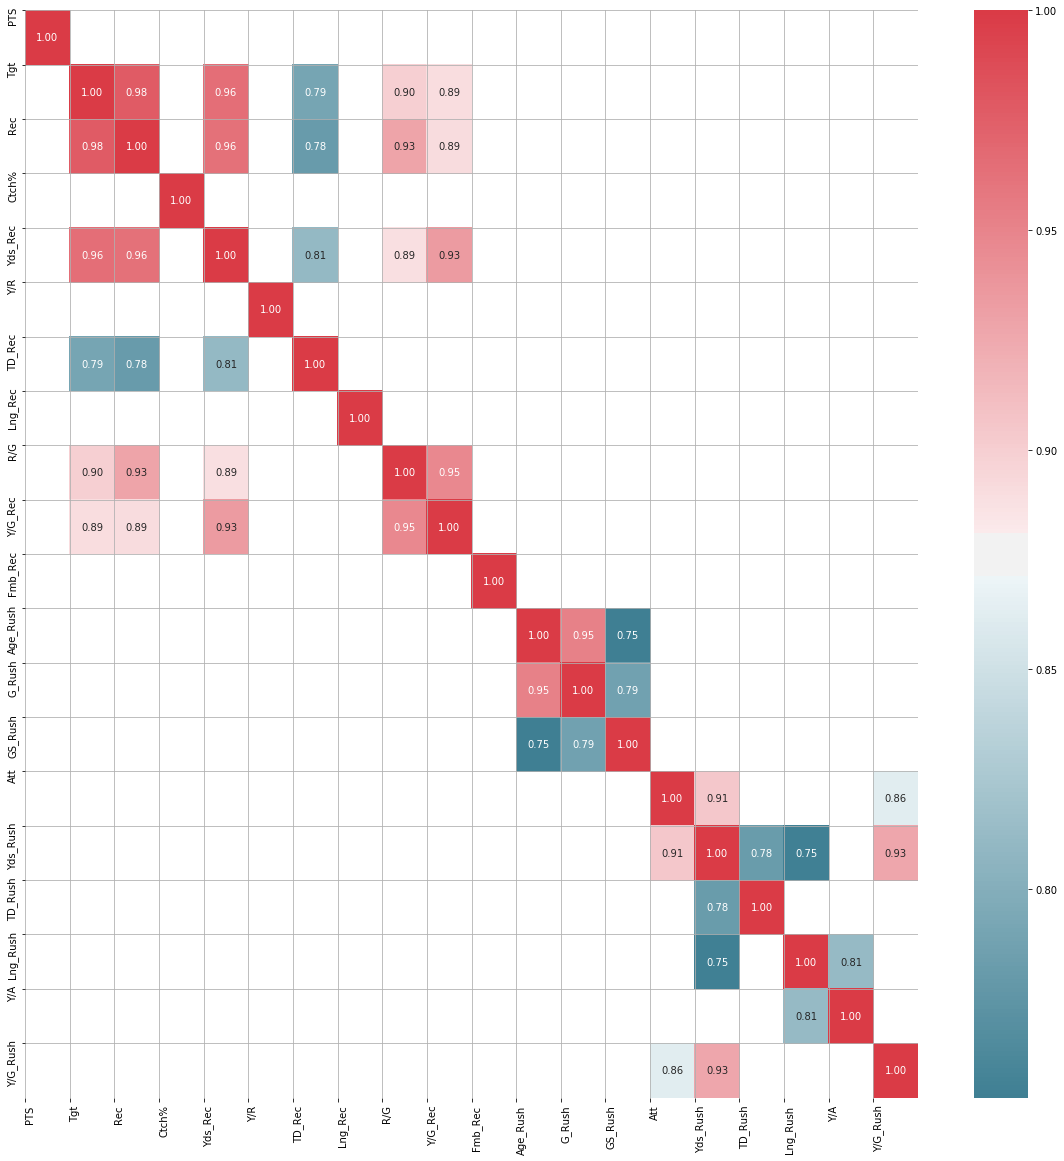

In [636]:
heatMap(df_wr)

# Simple Model Setup And Analysis

## Running Back Data

In [642]:
df_rb_lm_model=linear_regression_avg(df_rb,'PTS',None,None,True,True)

Train Val Scores: 0.4014369481576995
Train Test Scores: 0.24918237187465825
Test Scores: 0.3604832165331594
0.002665740376969659:Tgt
-0.3807254757010979:Rec
-27.373751529628855:Ctch%
0.00023235069606944013:Yds_Rec
-0.3616650433241955:Y/R
8.935783857568733:TD_Rec
-0.17087987888762476:Lng_Rec
12.003396257165976:R/G
0.46280359962495304:Y/G_Rec
-2.835109205307399:Fmb_Rec
-4.758427129241634:Age_Rush
4.686871719438207:G_Rush
-0.6958582056741042:GS_Rush
0.13879638483014678:Att
-0.038384822602201676:Yds_Rush
-0.843409117366355:TD_Rush
-0.3604071201931983:Lng_Rush
3.254231612527901:Y/A
1.9814696937304512:Y/G_Rush


In [19]:
df_rb_lasso_model=linear_regression_avg(df_rb,'PTS',"lasso",68,True,True)

Train Val Scores: 0.0
Train Test Scores: -0.0072898734072115
Test Scores: -0.062262499940562765
0.0:Tgt
0.0:Rec
0.0:Ctch%
0.0:Yds_Rec
0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.0:Y/G_Rec
0.0:Fmb_Rec
-0.0:Age_Rush
0.0:G_Rush
0.0:GS_Rush
0.0:Att
0.0:Yds_Rush
0.0:TD_Rush
0.0:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


In [691]:
df_rb_ridge_model=linear_regression_avg(df_rb,'PTS',"Ridge",None,True,True)

Lambda: 1.92
Train Val Scores: 0.4177036146821913
Train Test Scores: 0.276108225940462
Test Scores: 0.26484168906614103
0.1980818498511598:Tgt
-13.67619122160247:Rec
-8.279208705057089:Ctch%
0.7668686290548222:Yds_Rec
-0.7344672306258188:Y/R
16.035994187542364:TD_Rec
-10.367293428749951:Lng_Rec
22.772134386278:R/G
10.229470245976241:Y/G_Rec
7.2792746252741365:Fmb_Rec
-22.231106753858082:Age_Rush
21.84899910194129:G_Rush
-6.346255293071606:GS_Rush
8.474882283643467:Att
-7.550242152873553:Yds_Rush
-1.1228507160741918:TD_Rush
8.841152947186508:Lng_Rush
0.8690373446490327:Y/A
30.111099583378945:Y/G_Rush


## Wide Receiver Data

In [694]:
df_wr_lm_model=linear_regression_avg(df_rb,'PTS',None,None,True,True)

Train Val Scores: 0.4315395433235077
Train Test Scores: 0.22085531209006812
Test Scores: 0.3172592641504147
1.4251444167073135:Tgt
0.280674578655651:Rec
-12.174992914590298:Ctch%
-0.20181752814426673:Yds_Rec
-1.2376737018716755:Y/R
4.880187307643472:TD_Rec
-0.28567936053413573:Lng_Rec
-23.427185084966226:R/G
4.553894264794706:Y/G_Rec
-4.047292419686578:Fmb_Rec
-3.9849791479044416:Age_Rush
3.8587543284175543:G_Rush
0.09936651892762809:GS_Rush
-0.005439883721029916:Att
-0.007524428625225042:Yds_Rush
-0.8414437240340481:TD_Rush
-0.02378839969023664:Lng_Rush
2.8187162532512002:Y/A
1.7090786385234273:Y/G_Rush


In [698]:
df_wr_lasso_model=linear_regression_avg(df_rb,'PTS',"lasso",None,True,True)

Lambda: 2.0
Train Val Scores: 0.41326171435602366
Train Test Scores: 0.2696358872439026
Test Scores: 0.3063278677424405
0.0:Tgt
0.0:Rec
-1.9479045846145677:Ctch%
0.0:Yds_Rec
-0.7014893644894974:Y/R
14.898381785274461:TD_Rec
-0.0:Lng_Rec
16.353041583934353:R/G
0.0:Y/G_Rec
-0.0:Fmb_Rec
-11.452284485818277:Age_Rush
5.566309751315461:G_Rush
0.0:GS_Rush
0.0:Att
2.3572226925160376:Yds_Rush
0.0:TD_Rush
5.344336554808538:Lng_Rush
3.6832058227578974:Y/A
25.35675179386908:Y/G_Rush


In [697]:
df_wr_ridge_model=linear_regression_avg(df_rb,'PTS',"Ridge",None,True,True)

Lambda: 1.2000000000000002
Train Val Scores: 0.43792413887548315
Train Test Scores: 0.29168606317614787
Test Scores: 0.14821057785701208
-2.0814661815829174:Tgt
40.95581575770092:Rec
0.17131721098100014:Ctch%
-48.59243068275396:Yds_Rec
-4.179293623544432:Y/R
3.7938147056322515:TD_Rec
2.5798245478861697:Lng_Rec
21.91371880342787:R/G
16.408545161660953:Y/G_Rec
-8.993624636165139:Fmb_Rec
-18.166897936187695:Age_Rush
12.441492639696648:G_Rush
5.769580402236435:GS_Rush
3.7748914571504133:Att
-3.981329736947643:Yds_Rush
5.980071143776407:TD_Rush
3.5410150065878563:Lng_Rush
7.68904032046988:Y/A
18.436493545714093:Y/G_Rush


# Attempting To Normalize Data Distribution


### Running Back Model
**Linear Regression ended up performing best**

In [32]:
df_rb_log1=df_rb.copy()
df_rb_log2=df_rb.copy()
df_rb_log3=df_rb.copy()
df_rb_log4=df_rb.copy()
df_rb_log5=df_rb.copy()

In [33]:
df_rb_log1['log_pts']=df_rb_log1['PTS'].map(lambda x: log_function(x))
df_rb_log1=df_rb_log1.drop(columns='PTS')
df_rb_log2['log_pts_shift']=df_rb_log2['PTS'].map(lambda x: log_function_shift(x))
df_rb_log2=df_rb_log2.drop(columns='PTS')
df_rb_log3['boxcox_pts_shift'],bxcx_lambda=boxcox(df_rb_log3['PTS'].map(lambda x: x+1))
df_rb_log3=df_rb_log3.drop(columns='PTS')
df_rb_log4['sqrd_rt_pts']=df_rb_log4['PTS'].map(lambda x: math.sqrt(x))
df_rb_log4=df_rb_log4.drop(columns='PTS')
df_rb_log5['invrs_sq_pts_shift']=df_rb_log5['PTS'].map(lambda x: (x+1)**-.5)
df_rb_log5=df_rb_log5.drop(columns='PTS')

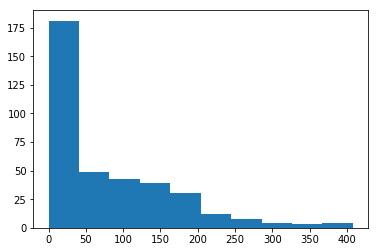

85.17084180498941
Train Val Scores: 0.3868564806697701
Train Test Scores: 0.3551520472716273
Test Scores: 0.2062672079931961
Lambda: 64.0
0.0:Tgt
0.0:Rec
0.0:Ctch%
0.16855593773995267:Yds_Rec
-0.0:Y/R
0.0:TD_Rec
-0.1586557007333736:Lng_Rec
0.0:R/G
0.11046963450857342:Y/G_Rec
-0.0:Fmb_Rec
-0.0:Age_Rush
-0.0:G_Rush
0.0:GS_Rush
0.0:Att
0.05279607658643956:Yds_Rush
-0.0:TD_Rush
-0.0:Lng_Rush
0.0:Y/A
0.5730876841245539:Y/G_Rush


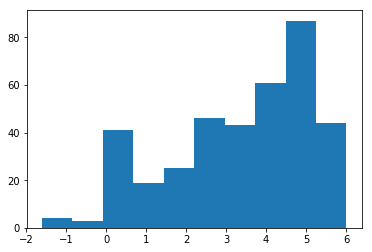

1.7892675000205984
Train Val Scores: 0.20599818804353118
Train Test Scores: 0.18716328927393366
Test Scores: 0.15517974399930157
Lambda: 17.2
0.0:Tgt
0.0:Rec
-0.0:Ctch%
0.000808250834896181:Yds_Rec
-0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.0:Y/G_Rec
-0.0:Fmb_Rec
-0.0:Age_Rush
-0.0:G_Rush
0.0:GS_Rush
0.0:Att
0.001673402007380331:Yds_Rush
-0.0:TD_Rush
0.0:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


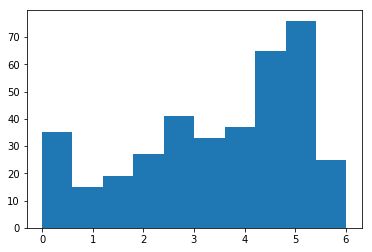

1.6777829602500027
Train Val Scores: 0.23582948545833254
Train Test Scores: 0.17095219636230644
Test Scores: 0.09655682092168516
Lambda: 2.96
0.0:Tgt
0.0:Rec
-0.0:Ctch%
0.0016477232916487247:Yds_Rec
-0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.0:Y/G_Rec
-0.0:Fmb_Rec
-0.0:Age_Rush
-0.0:G_Rush
-0.0:GS_Rush
-0.0002587173308455131:Att
0.001261636757999076:Yds_Rush
-0.0:TD_Rush
0.00335786909242022:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


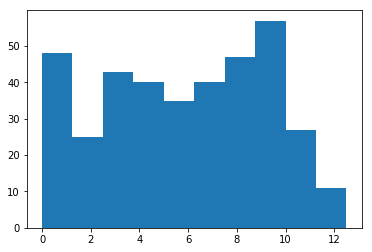

3.379947997758935
Train Val Scores: 0.27661653025740457
Train Test Scores: 0.23727761802397024
Test Scores: 0.18000869045681878
Lambda: 4.0
0.0:Tgt
0.0:Rec
0.0:Ctch%
0.0026449325134320126:Yds_Rec
-0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.0:Y/G_Rec
-0.0:Fmb_Rec
-0.0:Age_Rush
-0.0:G_Rush
-0.0:GS_Rush
-0.0028483954145551793:Att
0.0040578064485227:Yds_Rush
-0.0:TD_Rush
0.00959476269150156:Lng_Rush
0.0:Y/A
0.0027129358407419783:Y/G_Rush


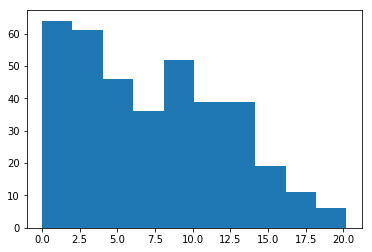

4.9928416236221445
Train Val Scores: 0.33558144219629726
Train Test Scores: 0.22218017251697209
Test Scores: 0.2840034163391104
Lambda: 4.0
0.0:Tgt
0.0:Rec
0.0:Ctch%
0.004666366540686783:Yds_Rec
-0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.023168332822739078:Y/G_Rec
-0.0:Fmb_Rec
-0.0:Age_Rush
-0.0:G_Rush
-0.0:GS_Rush
-0.0:Att
0.003261440758844409:Yds_Rush
-0.0:TD_Rush
0.030340333860252946:Lng_Rush
0.0:Y/A
0.005448677684323678:Y/G_Rush


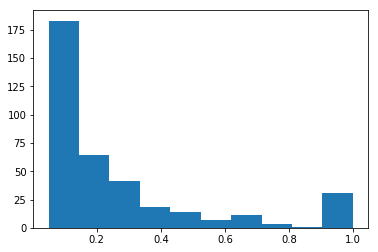

0.2670819908646332
Train Val Scores: 0.06323716400403016
Train Test Scores: 0.032181954648918376
Test Scores: 0.10305653055212938
Lambda: 3.6639999999999997
-0.0:Tgt
-0.0:Rec
-0.0:Ctch%
-3.485774161043315e-05:Yds_Rec
-0.0:Y/R
-0.0:TD_Rec
-0.0:Lng_Rec
-0.0:R/G
-0.0:Y/G_Rec
0.0:Fmb_Rec
0.0:Age_Rush
-0.0:G_Rush
-0.0:GS_Rush
-0.0:Att
-0.00013442646766239963:Yds_Rush
-0.0:TD_Rush
-0.0:Lng_Rush
-0.0:Y/A
-0.0:Y/G_Rush


Lasso(alpha=3.6639999999999997, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
#Regular
plt.hist(df_rb['PTS'])
plt.show()
print(np.std(df_rb['PTS']))
regression_avg_normalization(df_rb,'PTS',"LASSO",None,True,True)

#Logged
plt.hist(df_rb_log1['log_pts'])
plt.show()
print(np.std(df_rb_log1['log_pts']))
regression_avg_normalization(df_rb_log1,'log_pts',"LASSO",None,True,True)


#Logged Shifted
plt.hist(df_rb_log2['log_pts_shift'])
plt.show()
print(np.std(df_rb_log2['log_pts_shift']))
regression_avg_normalization(df_rb_log2,'log_pts_shift',"LASSO",None,True,True)


#BoxCox Logged
plt.hist(df_rb_log3['boxcox_pts_shift'])
plt.show()
print(np.std(df_rb_log3['boxcox_pts_shift']))
regression_avg_normalization(df_rb_log3,'boxcox_pts_shift',"LASSO",None,True,True)

#Squared Root
plt.hist(df_rb_log4['sqrd_rt_pts'])
plt.show()
print(np.std(df_rb_log4['sqrd_rt_pts']))
regression_avg_normalization(df_rb_log4,'sqrd_rt_pts',"LASSO",None,True,True)

#Inverse Sqrd
plt.hist(df_rb_log5['invrs_sq_pts_shift'])
plt.show()
print(np.std(df_rb_log5['invrs_sq_pts_shift']))
regression_avg_normalization(df_rb_log5,'invrs_sq_pts_shift',"LASSO",None,True,True)


### Wide Receiver Model
**Wide Receiver Model ended up performing best**

In [56]:
df_wr_log1=df_wr.copy()
df_wr_log2=df_wr.copy()
df_wr_log3=df_wr.copy()
df_wr_log4=df_wr.copy()
df_wr_log5=df_wr.copy()

df_wr_log1['log_pts']=df_wr_log1['PTS'].map(lambda x: log_function(x))
df_wr_log1=df_wr_log1.drop(columns='PTS')
df_wr_log2['log_pts_shift']=df_wr_log2['PTS'].map(lambda x: log_function_shift(x))
df_wr_log2=df_wr_log2.drop(columns='PTS')
df_wr_log3['boxcox_pts_shift'],bxcx_lambda=boxcox(df_wr_log3['PTS'].map(lambda x: x+1))
df_wr_log3=df_wr_log3.drop(columns='PTS')
df_wr_log4['sqrd_rt_pts']=df_wr_log4['PTS'].map(lambda x: math.sqrt(x))
df_wr_log4=df_wr_log4.drop(columns='PTS')
df_wr_log5['invrs_sq_pts_shift']=df_wr_log5['PTS'].map(lambda x: (x+1)**-.5)
df_wr_log5=df_wr_log5.drop(columns='PTS')

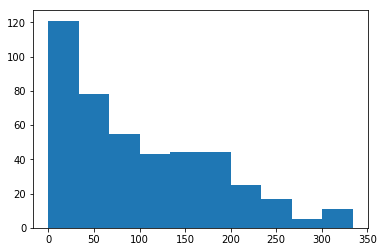

83.5227602733312
Train Val Scores: 0.4568190745431343
Train Test Scores: 0.39718613124164814
Test Scores: 0.4435069992104631
Lambda: 7.52
-0.0995474397169373:Tgt
0.7427280407179725:Rec
-0.0:Ctch%
0.0006386843430808591:Yds_Rec
-0.0:Y/R
0.6392950292704305:TD_Rec
-0.0:Lng_Rec
0.0:R/G
1.4444555434985569:Y/G_Rec
-0.0:Fmb_Rec
-0.0945471491791474:Age_Rush
0.0:G_Rush
0.576650954615561:GS_Rush
0.0:Att
0.05585488049416929:Yds_Rush
0.0:TD_Rush
0.19396129147490723:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


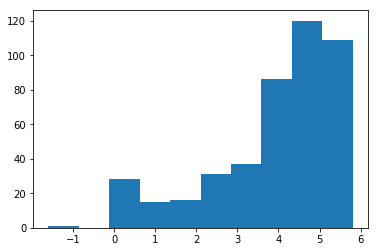

1.5198293173620223
Train Val Scores: 0.22304557206909198
Train Test Scores: 0.18525323218685902
Test Scores: 0.2537872801848714
Lambda: 4.4
0.0:Tgt
0.0:Rec
-0.0:Ctch%
0.0017721904684443342:Yds_Rec
0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.0:Y/G_Rec
-0.0:Fmb_Rec
-0.0:Age_Rush
0.0:G_Rush
-0.0:GS_Rush
0.0:Att
0.00026107295401500414:Yds_Rush
0.0:TD_Rush
0.0:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


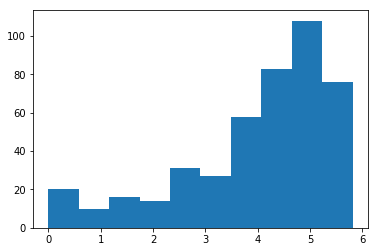

1.453662176624363
Train Val Scores: 0.2365738781511953
Train Test Scores: 0.22431552993413142
Test Scores: 0.2261480623533908
Lambda: 2.0
0.0:Tgt
0.0:Rec
-0.0:Ctch%
0.001797331509994508:Yds_Rec
0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.0:Y/G_Rec
-0.0:Fmb_Rec
0.0:Age_Rush
0.0:G_Rush
0.0:GS_Rush
0.0:Att
0.0022448191851789593:Yds_Rush
0.0:TD_Rush
0.0:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


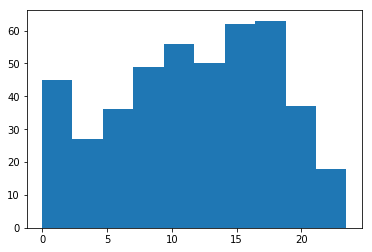

6.180489254727831
Train Val Scores: 0.34881603712949577
Train Test Scores: 0.3107200374729331
Test Scores: 0.4873967020928547
Lambda: 2.48
0.0:Tgt
-0.0:Rec
-0.0:Ctch%
0.0074476393626925685:Yds_Rec
0.0:Y/R
0.0:TD_Rec
0.0168237734187286:Lng_Rec
0.0:R/G
0.02763163486321605:Y/G_Rec
-0.0:Fmb_Rec
0.0:Age_Rush
0.0:G_Rush
0.0:GS_Rush
0.0:Att
0.0077896707098926:Yds_Rush
-0.0:TD_Rush
0.0:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


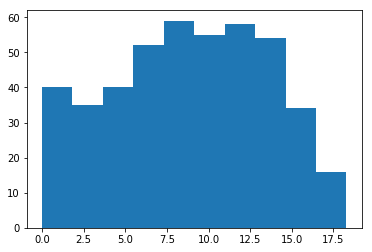

4.6818636459866765
Train Val Scores: 0.4250254747498749
Train Test Scores: 0.36949909678016757
Test Scores: 0.21186417095344057
Lambda: 1.4560000000000002
0.017511371346296635:Tgt
0.0:Rec
0.0:Ctch%
0.0007430465687554153:Yds_Rec
0.0:Y/R
-0.0:TD_Rec
0.021151927973539708:Lng_Rec
0.0:R/G
0.06436056098083805:Y/G_Rec
-0.0:Fmb_Rec
-0.0:Age_Rush
0.0:G_Rush
0.0:GS_Rush
-0.0:Att
0.00721288794426055:Yds_Rush
-0.0:TD_Rush
0.0:Lng_Rush
-0.0:Y/A
0.0:Y/G_Rush


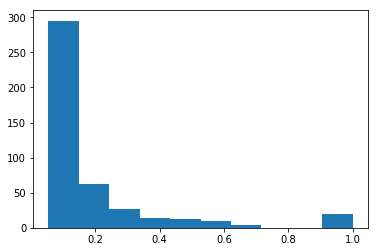

0.21258624724244604
Train Val Scores: 0.07511784767373697
Train Test Scores: 0.0744171169709615
Test Scores: 0.06325542158641606
Lambda: 3.5999999999999996
-0.0:Tgt
-0.0:Rec
0.0:Ctch%
-0.00010696174277574889:Yds_Rec
-0.0:Y/R
-0.0:TD_Rec
-0.0:Lng_Rec
-0.0:R/G
-0.0:Y/G_Rec
0.0:Fmb_Rec
-0.0:Age_Rush
-0.0:G_Rush
-0.0:GS_Rush
-0.0:Att
-0.0:Yds_Rush
-0.0:TD_Rush
-0.0:Lng_Rush
-0.0:Y/A
-0.0:Y/G_Rush


Lasso(alpha=3.5999999999999996, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [57]:
#Regular
plt.hist(df_wr['PTS'])
plt.show()
print(np.std(df_wr['PTS']))
regression_avg_normalization(df_wr,'PTS',"LASSO",None,True,True)

#Logged
plt.hist(df_wr_log1['log_pts'])
plt.show()
print(np.std(df_wr_log1['log_pts']))
regression_avg_normalization(df_wr_log1,'log_pts',"LASSO",None,True,True)

#Logged Shifted
plt.hist(df_wr_log2['log_pts_shift'])
plt.show()
print(np.std(df_wr_log2['log_pts_shift']))
regression_avg_normalization(df_wr_log2,'log_pts_shift',"LASSO",None,True,True)

#BoxCox Logged
plt.hist(df_wr_log3['boxcox_pts_shift'])
plt.show()
print(np.std(df_wr_log3['boxcox_pts_shift']))
regression_avg_normalization(df_wr_log3,'boxcox_pts_shift',"LASSO",None,True,True)

#Squared Root
plt.hist(df_wr_log4['sqrd_rt_pts'])
plt.show()
print(np.std(df_wr_log4['sqrd_rt_pts']))
regression_avg_normalization(df_wr_log4,'sqrd_rt_pts',"LASSO",None,True,True)

#Inverse Sqrd
plt.hist(df_wr_log5['invrs_sq_pts_shift'])
plt.show()
print(np.std(df_wr_log5['invrs_sq_pts_shift']))
regression_avg_normalization(df_wr_log5,'invrs_sq_pts_shift',"LASSO",None,True,True)


# Use Lasso To Find Best Features
## Normal Features

### Wide Receivers

In [61]:
lambda_tester(df_wr,'PTS',46,82,True,20)

46
0.4109080504519269
0.4242973798954157


47
0.4107768373767928
0.4370299928025685


58
0.4057959394228682
0.4533757083448942


0.000784453187410809:Tgt
0.006866068126056321:Rec
0.0:Ctch%
0.04415493082066762:Yds_Rec
-0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
1.682077108284885:Y/G_Rec
-0.0:Fmb_Rec
0.0:Age_Rush
0.0:G_Rush
0.0:GS_Rush
0.0:Att
0.21403716253508023:Yds_Rush
0.0:TD_Rush
0.0:Lng_Rush
0.0:Y/A
0.0:Y/G_Rush


### Running Backs

In [63]:
lambda_tester(df_rb,'PTS',40,60,True,20)

40
0.28292767472500846
0.3281915771304341


50
0.2858095127084
0.32894952585723847


0.0221137469834141:Tgt
0.0:Rec
-0.0:Ctch%
0.10537722250689044:Yds_Rec
-0.0:Y/R
0.0:TD_Rec
0.0:Lng_Rec
0.0:R/G
0.1945544418347676:Y/G_Rec
-0.0:Fmb_Rec
-0.0819939496836326:Age_Rush
-0.0:G_Rush
-0.0:GS_Rush
-0.0:Att
0.03605699412165946:Yds_Rush
0.0:TD_Rush
0.1886880550990948:Lng_Rush
0.0:Y/A
0.6612893740639976:Y/G_Rush


## Polynomial Features

### Wide Receiver
**Polynomial Regression didn't improve R^2**

In [65]:
df_wr_poly=df_wr.loc[:,['PTS','Yds_Rec','Y/G_Rec','Yds_Rush']]
poly=PolynomialFeatures(2)
df_wr_poly1=poly.fit_transform(df_wr_poly.iloc[:,1:])
df_wr_poly1=pd.DataFrame(df_wr_poly1)
df_wr_poly1=df_wr_poly1.drop(0,axis=1,)
df_wr_poly=df_wr_poly.drop(['Yds_Rec','Y/G_Rec','Yds_Rush'],axis=1)
y=df_wr_poly.iloc[:,0]
i,i,j,t=Lasso_Reg(df_wr_poly1,y,3)


In [68]:
lambda_tester(df_wr_poly1,y,20,60,True,20)

20
0.3673190520286553
0.38930732147149055


21
0.3686987432872916
0.40641027422554155


26
0.37684203201860234
0.4047536254571286


31
0.3854481848956236
0.4088641611091625


35
0.38650428707471945
0.4081618069075082


39
0.3700825420698308
0.4285150621825294


41
0.3657000873972474
0.44153099515758226


45
0.38299354938787916
0.4317563111660422


0.07329856057245178:1
0.0:2
0.0:3
0.00020749538491598096:4
-0.004764292629961384:5
0.001430774688899554:6
0.03644662366957821:7
-0.026334760239279924:8
0.0023835017600293915:9


### Running Back
**Polynomial Regression didn't improve R^2**

In [69]:
df_rb_poly=df_rb.loc[:,['PTS','Age_Rush','Yds_Rec','Att','Lng_Rush','Tgt','Y/G_Rush']]
df_rb_poly1=poly.fit_transform(df_rb_poly.iloc[:,1:])
df_rb_poly1=pd.DataFrame(df_rb_poly1)
df_rb_poly1=df_rb_poly1.drop(0,axis=1,)
df_rb_poly=df_rb_poly.drop(['Age_Rush','Yds_Rec','Att','Lng_Rush','Tgt','Y/G_Rush'],axis=1)
y=df_rb_poly.iloc[:,0]

In [70]:
lambda_tester(df_rb_poly1,y,30,80,True,20)

30
0.23974169659238573
0.22597057586238906


31
0.22297031896434064
0.24684465154442817


34
0.18870495216757122
0.319910722290693


51
0.23502621857990827
0.2737931896539388


67
0.20804062768732706
0.30697732510483455


77
0.20809422137064934
0.3137896715946371


0.0:1
0.6792772657298964:2
0.13327861136232702:3
0.0:4
0.0:5
0.0:6
-0.030859179327739787:7
-0.019206520864016127:8
0.0026960830730708234:9
0.024092221968478867:10
-0.05132596656287502:11
0.0:12
-0.001032769624876784:13
-0.0007480519375856786:14
0.00037661765625270646:15
0.01316019605529447:16
-0.0035185005606094707:17
0.00178527069213453:18
-0.030799826374982506:19
-0.00035702331531719:20
0.006874375939528082:21
0.0:22
0.022927487173153998:23
0.05121159357392295:24
-0.03454359858025566:25
0.03945915206822246:26
-0.009067345192066175:27


# Pull in Lasso Selected Features For Both Positions

In [71]:
df_wr = df_wr.loc[:,['PTS','Yds_Rec','Y/G_Rec','Yds_Rush']]
df_rb=df_rb.loc[:,['PTS','Age_Rush','Yds_Rec','Tgt','Y/G_Rush']]

# Final Model Checks
**I checked Lasso and Ridge regularization, neither improved the model**

### RB Model

In [84]:
regression_avg(df_rb,'PTS',False,500)

Train Val Scores: 0.36732120972225996
Train Test Scores: 0.3083383692105358
Test Scores: 0.31686717563920885


### WR Model

In [85]:
regression_avg(df_wr,'PTS',False,500)

Train Val Scores: 0.4552908298091342
Train Test Scores: 0.42234003474509907
Test Scores: 0.42311584956735543


# Model Analysis

## Predictions For The Top 5 Fantasy Performer For Each Position

### Wide Receiver

In [119]:
df_wr_predict_x=df_wr_18[['Yds_Rec', 'Y/G_Rec', 'Yds_Rush']]

WR_Fantasy_Pts_Predict=wr_model.predict(df_wr_predict_x)

df_wr_18.reset_index(inplace=True)
df_wr_names_predict=pd.concat([pd.Series(WR_Fantasy_Pts_Predict),df_wr_18],axis=1,ignore_index=True)

df_wr_names_predict.sort_values(by=0,ascending=False).head(5)

,0,1,2,3,4,5
2,299.531563,3,1677.0,104.8,12.0,juliojones18
9,282.200237,14,1479.0,92.4,151.0,tyreekhill18
1,279.273170,2,1572.0,98.3,-7.0,deandrehopkins18
10,271.873300,16,1524.0,95.3,0.0,mikeevans18
5,256.556119,6,1426.0,89.1,13.0,jujusmithschuster18


### Running Back

In [123]:
df_rb_predict_x=df_rb_18[['Age_Rush', 'Yds_Rec', 'Tgt', 'Y/G_Rush']]

RB_Fantasy_Pts_Predict=rb_model.predict(df_rb_predict_x)
df_rb_18.reset_index(inplace=True)

df_rb_names_predict=pd.concat([pd.Series(RB_Fantasy_Pts_Predict),df_rb_18],axis=1,ignore_index=True)

df_rb_names_predict.sort_values(by=0,ascending=False).head(5)

,0,1,2,3,4,5,6,7
0,312.283832,0,7,22.0,867.0,124.0,68.6,christianmccaffrey18
1,299.833476,1,12,21.0,721.0,121.0,81.7,saquonbarkley18
4,268.494459,4,22,23.0,567.0,95.0,95.6,ezekielelliott18
3,260.849302,3,18,23.0,709.0,105.0,58.9,alvinkamara18
8,253.903636,8,53,24.0,580.0,81.0,89.4,toddgurley18



# Graphing

## Observed vs Predicted Plots

In [126]:
style.use('bmh')

### Wide Receiver

In [132]:
predicted_y_wr=wr_model.predict(df_wr[['Yds_Rec', 'Y/G_Rec', 'Yds_Rush']])
df_wr_obs_pred=pd.concat([pd.DataFrame(df_wr.loc[:,['PTS']]).reset_index(drop=True),pd.DataFrame(predicted_y_wr)],join='inner',axis=1,ignore_index=False)
df_wr_obs_pred.columns=['PTS','Predicted_PTS']

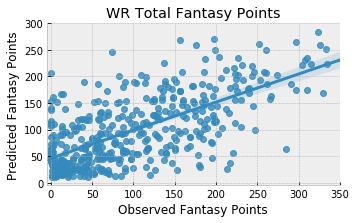

In [133]:
ax=sns.lmplot('PTS','Predicted_PTS',df_wr_obs_pred,)
fig=plt.gcf()
fig.set_size_inches(5,3)
fig.subplots_adjust(bottom=.15,top=.9)
plt.ylim(-5,300)
plt.xlim(-5,350)
ax.set(xlabel="Observed Fantasy Points",ylabel="Predicted Fantasy Points",title="WR Total Fantasy Points")
plt.savefig('WR_Predicted_Observed.png',format='png',dpi=1000)
plt.show()


### Running Back

In [134]:
predicted_y_rb=rb_model.predict(df_rb[['Age_Rush', 'Yds_Rec', 'Tgt', 'Y/G_Rush']])
df_rb_obs_pred=pd.concat([pd.DataFrame(df_rb.loc[:,['PTS']]).reset_index(drop=True),pd.DataFrame(predicted_y_rb)],join='inner',axis=1,ignore_index=False)
df_rb_obs_pred.columns=['PTS','Predicted_PTS']

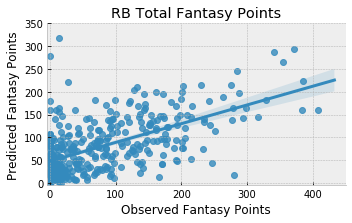

In [136]:
ax=sns.lmplot('PTS','Predicted_PTS',df_rb_obs_pred,)
fig=plt.gcf()
plt.tight_layout()
fig.set_size_inches(5,3)
fig.subplots_adjust(bottom=.15,top=.9)
plt.ylim(-5,350)
plt.xlim(-5,450)
ax.set(xlabel="Observed Fantasy Points",ylabel="Predicted Fantasy Points",title="RB Total Fantasy Points")
plt.savefig('RB_Predicted_Observed.jpg',format='jpg',dpi=1000)
plt.show()

# Model Scores

## RMSE And Adjusted R^2

### WR

In [144]:
# Adjusted R^2
y_obs_wr=df_wr.loc[:,['PTS']]
adj_wr = 1 - float(len(df_wr.loc[:,['PTS']])-1)/(len(df_wr.loc[:,['PTS']])-len(wr_model.coef_)-1)*(1 - metrics.r2_score(df_wr.loc[:,['PTS']],predicted_y_wr))
print(adj_wr)


0.42348988585134073


In [143]:
# Mean_Squared_Error
np.sqrt(mean_squared_error(y_obs_wr,predicted_y_wr))

63.20179740187381

### RB

In [145]:
# Adjusted R^2
y_obs_rb=df_rb.loc[:,['PTS']]
adj_rb = 1 - float(len(df_rb.loc[:,['PTS']])-1)/(len(df_rb.loc[:,['PTS']])-len(rb_model.coef_)-1)*(1 - metrics.r2_score(df_rb.loc[:,['PTS']],predicted_y_rb))
print(adj_rb)


0.3244501797458862


In [146]:
# Mean Squared Error
np.sqrt(mean_squared_error(y_obs_rb,predicted_y_rb))

69.62610015681585

# Feature Ranking

## WR

In [151]:
X_wr=df_wr_allFeat.drop(columns='PTS').astype(float)
y_wr=df_wr_allFeat.loc[:,['PTS']].astype(float)
y_wr=y_wr.iloc[:,0]
alpha_wr,active_wr,coef=lars_path(np.array(X_wr),np.array(y_wr),method='lasso')

In [152]:
for i in range(len(active_wr)):
    print(str(active_wr[i]) + ': ' + str(X_wr.columns[i]))

6: Age_Rush
14: Att
9: Ctch%
7: Fmb_Rush
0: GS_Rush
10: G_Rush
12: Lng_Rec
16: Lng_Rush
15: R/G
18: Rec
1: TD_Rec
13: TD_Rush
5: Tgt
4: Y/A
3: Y/G_Rec
2: Y/G_Rush
11: Y/R
8: Yds_Rec
17: Yds_Rush


## RB

In [153]:
X_rb=df_rb_allFeat.drop(columns='PTS').astype(float)
y_rb=df_rb_allFeat.loc[:,['PTS']].astype(float)
y_rb=y_rb.iloc[:,0]

In [154]:
alpha_rb,active_rb,coef=lars_path(np.array(X_rb),np.array(y_rb),method='lasso')

In [155]:
for i in range(len(active_rb)):
    print(str(active_rb[i]) + ': ' + str(X_rb.columns[i]))

15: Age_Rush
7: Att
6: Ctch%
12: Fmb_Rush
1: GS_Rush
14: G_Rush
0: Lng_Rec
9: Lng_Rush
5: R/G
10: Rec
3: TD_Rec
13: TD_Rush
16: Tgt
2: Y/A
4: Y/G_Rec
18: Y/G_Rush
11: Y/R
8: Yds_Rec
17: Yds_Rush
